In [1]:
%matplotlib inline

import requests
import json
import datetime
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
MIN_LAT = 37.701933
MAX_LAT = 38.008050
MIN_LON = -122.536985
MAX_LON = -122.186437

last_hour = datetime.datetime.now().strftime("%Y-%m-%dT%H")
last_12_hours = datetime.datetime.now() + relativedelta(hours=-12)
last_12_hours = last_12_hours.strftime("%Y-%m-%dT%H")

In [3]:
EPA_URL = "http://www.airnowapi.org/aq/data/"
params = {"startDate":last_12_hours,
          "endDate":last_hour,
          "parameters":"OZONE,PM25,PM10,CO,NO2,SO2",
          "BBOX":f"{MIN_LON},{MIN_LAT},{MAX_LON},{MAX_LAT}",
          "dataType":"B",
          "format":"application/json",
          "verbose":1,
          "nowcastonly":1,
          "includerawconcentrations":1,
          "API_KEY":"8FA4FE40-BEC5-4265-B251-D29F48C142D1"}

In [4]:
r = requests.get(EPA_URL, params = params)
r.status_code

200

In [5]:
results = r.json()

In [6]:
len(results)

247

In [7]:
results[0]

{'Latitude': 37.9722,
 'Longitude': -122.5189,
 'UTC': '2019-10-03T03:00',
 'Parameter': 'OZONE',
 'Unit': 'PPB',
 'Value': 27.0,
 'RawConcentration': 26.7,
 'AQI': 25,
 'Category': 1,
 'SiteName': 'San Rafael',
 'AgencyName': 'San Francisco Bay Area AQMD',
 'FullAQSCode': '060410001',
 'IntlAQSCode': '840060410001'}

Note to self: -999s are used for missing values

In [8]:
df = pd.DataFrame(results)
gdf = gpd.GeoDataFrame(df, geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)])

In [9]:
gdf.head()

,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode,geometry
0,37.9722,-122.5189,2019-10-03T03:00,OZONE,PPB,27.00,26.700,25,1,San Rafael,San Francisco Bay Area AQMD,060410001,840060410001,POINT (-122.5189 37.9722)
1,37.9722,-122.5189,2019-10-03T03:00,PM2.5,UG/M3,3.80,3.000,16,1,San Rafael,San Francisco Bay Area AQMD,060410001,840060410001,POINT (-122.5189 37.9722)
2,37.9722,-122.5189,2019-10-03T03:00,NO2,PPB,3.00,3.800,3,1,San Rafael,San Francisco Bay Area AQMD,060410001,840060410001,POINT (-122.5189 37.9722)
3,37.9722,-122.5189,2019-10-03T03:00,CO,PPM,0.12,0.121,-999,0,San Rafael,San Francisco Bay Area AQMD,060410001,840060410001,POINT (-122.5189 37.9722)
4,37.7658,-122.3978,2019-10-03T03:00,PM2.5,UG/M3,5.50,6.000,23,1,San Francisco,San Francisco Bay Area AQMD,060750005,840060750005,POINT (-122.3978 37.7658)


In [11]:
# shape file that has map background
base = gpd.read_file("../../bayarea.json")

In [14]:
cities = gpd.read_file("../../CA_Places_TIGER2016.shp")

(37.701933, 38.00805)

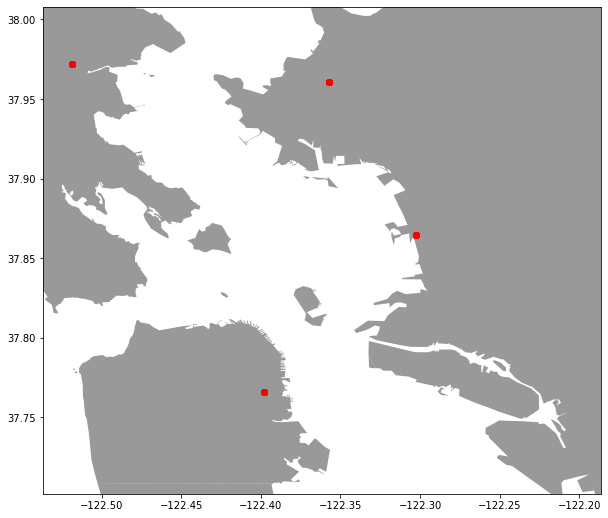

In [41]:
fig, ax = plt.subplots(figsize = (10,10))
base[base['AREA_NAME'] == 'Other'].plot(ax = ax, alpha = 0.8, color = 'grey')
base[base['AREA_NAME'] == 'San Francisco'].plot(ax = ax, alpha = 0.8, color = 'grey')
gdf[gdf['Parameter'] == 'PM2.5'].plot(ax = ax, color = 'red')
ax.set_xlim(MIN_LON, MAX_LON)
ax.set_ylim(MIN_LAT, MAX_LAT)

In [40]:
# who has what kind of sensors then
gdf.groupby('SiteName').agg({'Parameter':'unique'})

,Parameter
SiteName,
Berkeley Aquatic Park,"[PM2.5, OZONE, NO2, CO]"
Laney College,"[NO2, CO]"
Richmond - 7th St,[SO2]
San Francisco,"[PM2.5, OZONE, NO2, CO]"
San Pablo - Rumrill,"[PM2.5, NO2, OZONE, SO2, CO]"
San Rafael,"[OZONE, PM2.5, NO2, CO]"


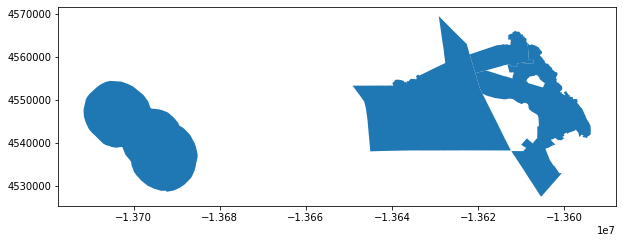

In [25]:
fig, ax = plt.subplots(figsize = (10,10))

cities[cities.NAME.isin(['San Francisco', 'Oakland', 'Berkeley'])].plot(ax=ax)

In [ ]:
# wtf is that

In [23]:
cities.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,G4110,A,6148697,0,+34.2886519,-118.4362413,POLYGON ((-13186463.85473168 4067122.650716818...
1,06,14190,02409487,0614190,Cloverdale,Cloverdale city,25,C1,N,N,G4110,A,7863863,59201,+38.7959624,-123.0153700,POLYGON ((-13696207.84639312 4691208.337768598...
2,06,16560,02410240,0616560,Cotati,Cotati city,25,C1,N,N,G4110,A,4869007,8380,+38.3284920,-122.7100491,"POLYGON ((-13662197.83825167 4626644.61350646,..."
3,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,G4110,A,56500370,27033715,+34.2677796,-119.2542062,(POLYGON ((-13280094.13783886 4075172.87791196...
4,06,30014,02410601,0630014,Glendora,Glendora city,25,C1,N,N,G4110,A,50251851,403066,+34.1449667,-117.8476672,"POLYGON ((-13123577.79273059 4048398.24812131,..."


In [31]:
import fiona; fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}